## Setup: Install Dependencies
Run this once to load project libs (requests, pandas, etc.).

In [10]:
# Install from requirements.txt (run once)
%pip install -r ../requirements.txt
print('✅ Deps installed—restart kernel if needed (Kernel > Restart).')

  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached azure_monitor_query-1.2.0-py3-none-any.whl.metadata (32 kB)
  Using cached azure_identity-1.17.0-py3-none-any.whl.metadata (79 kB)
  Using cached pandas-2.1.4.tar.gz (4.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.
✅ Deps installed—restart kernel if needed (Kernel > Restart).


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [55 lines of output]
      Ignoring oldest-supported-numpy: markers 'python_version < "3.12"' don't match your environment
        Using cached meson_python-0.13.1-py3-none-any.whl.metadata (4.1 kB)
        Using cached meson-1.2.1-py3-none-any.whl.metadata (1.7 kB)
        Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
        Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
        Using cached numpy-1.26.4.tar.gz (15.8 MB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Installing backend dependencies: started
        Installing backend dependencies: finished with status 'done'
        Preparing metadata (pyproject.tom

# AIOps Anomaly Detection: Interactive Demo

**Overview**: Offline simulation of automated anomaly detection for IT ops (e.g., Azure VM CPU metrics). 
- Learns 'normal' patterns from time-series data.
- Flags deviations without manual thresholds.
- Visualizes actual vs. expected for proactive downtime prevention.

**Tune & Re-run**: Change `anomaly_prob` or `num_points` in Cell 3, then re-execute.

Future: Replace mocks with Azure Monitor fetches for real data.

In [11]:
# Imports (path to root for src/)
%matplotlib inline 
import matplotlib.pyplot as plt
plt.ioff()  # Disable interactive mode (stops empty windows)
import sys
import random
sys.path.append('..')
from src.detect_anomalies import create_payload_with_anomalies
from src.visualize_anomalies import plot_detection
from datetime import datetime
%env ANOMALY_DETECTOR_ENDPOINT=https://anomalydetector-vtmarvj2flhgk.cognitiveservices.azure.com/
%env ANOMALY_DETECTOR_KEY=d7d7498c94d4461fbe5a73a70b7a3330

env: ANOMALY_DETECTOR_ENDPOINT=https://anomalydetector-vtmarvj2flhgk.cognitiveservices.azure.com/
env: ANOMALY_DETECTOR_KEY=d7d7498c94d4461fbe5a73a70b7a3330


In [12]:
# Step 1: Generate synthetic time-series data
# Simulates metrics like CPU % with patterns + random anomalies (spikes/drops)
random.seed(42)  # Reproducible for demos
payload = create_payload_with_anomalies(
    num_points=50,  # e.g., 50 mins of data
    anomaly_prob=0.15,  # 15% deviation chance (tune here!)
    base_value=75  # Normal baseline
)
print(f"Generated {len(payload['series'])} points with ~{int(0.15*50)} expected anomalies.")
print("Sample data:", payload['series'][:3])  # Peek at first points

Generated 50 points with ~7 expected anomalies.
Sample data: [{'timestamp': '2025-10-09T19:28:00Z', 'value': 79.19476742385832}, {'timestamp': '2025-10-09T19:29:00Z', 'value': 78.00571896127943}, {'timestamp': '2025-10-09T19:30:00Z', 'value': 84.78626478630558}]


In [13]:
# Step 2: Mock Detection (AIOps 'learns' patterns & flags deviations)
# Real: Call Azure Anomaly Detector API with env vars
result = {
    'isAnomaly': True,  # Overall flag
    'expectedValues': [75] * len(payload['series']),  # Mock learned baseline
    'anomalyStatus': [1 if random.random() < 0.15 else 0 for _ in payload['series']]  # Per-point flags
}
anomaly_count = sum(result['anomalyStatus'])
print(f"Mock detection: {anomaly_count} anomalies flagged! 🚨\n(Proactive alert: Auto-scale resources?)")

Mock detection: 9 anomalies flagged! 🚨
(Proactive alert: Auto-scale resources?)


In [14]:
# Step 3: Visualize (actual vs. expected, red dots on deviations)
import matplotlib.pyplot as plt  # For post-plot saves

# Debug: Print payload to confirm data exists
print("Debug: Payload series length:", len(payload['series']))
print("Debug: Sample values:", [p['value'] for p in payload['series'][:5]])

plot_detection(payload, result, save_path='anomaly_demo_nb.png', show_plot=False)  # No plt.show() = no pop-up
print("Plot rendered—check inline/PNG for spikes & reds!")

# Tweak: Auto-save timestamped high-res PNG to repo (for commits)
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_name = f"anomaly_demo_{timestamp}.png"
plt.savefig(save_name, dpi=150, bbox_inches='tight', facecolor='white')  # Saves open figure
print(f"📸 Timestamped plot saved: {save_name} (check file size >50KB for content)")

Debug: Payload series length: 50
Debug: Sample values: [79.19476742385832, 78.00571896127943, 84.78626478630558, 83.62510800075151, 81.08970211438172]
📊 Plot saved to anomaly_demo_nb.png
Plot rendered—check inline/PNG for spikes & reds!
📸 Timestamped plot saved: anomaly_demo_20251009_201707.png (check file size >50KB for content)


In [15]:
# Step 2.5: Live Azure API Test (Optional—Use Real Detection)
# Set env vars in terminal, then toggle for live run
use_real_api = True  # Set True to call real Anomaly Detector (requires endpoint/key)

import os  # Import for getenv

# Set env vars here for Jupyter kernel (overrides terminal if needed)
os.environ["ANOMALY_DETECTOR_ENDPOINT"] = "https://anomalydetector-vtmarvj2flhgk.cognitiveservices.azure.com/"
os.environ["ANOMALY_DETECTOR_KEY"] = "d7d7498c94d4461fbe5a73a70b7a3330"

if use_real_api:
    endpoint = os.getenv("ANOMALY_DETECTOR_ENDPOINT")
    api_key = os.getenv("ANOMALY_DETECTOR_KEY")
    print(f"Debug: Endpoint: {endpoint}")  # Full for verification
    if api_key:  # Check before slicing
        print(f"Debug: Key (partial): {api_key[:10]}...")  # Partial for security
    else:
        print("Debug: Key: None")
    if endpoint and api_key:
        from src.detect_anomalies import detect_via_api
        result = detect_via_api(payload, endpoint, api_key)  # Real call
        print("🔴 Live Azure API: Real detection results!")
        print(f"API Response: isAnomaly={result.get('isAnomaly')}, expectedChangePoint={result.get('expectedChangePoint')}")
    else:
        print("⚠️ Env vars missing—staying in mock mode.")
        # Fallback to mock
        result = {
            'isAnomaly': True,
            'expectedValues': [75] * len(payload['series']),
            'anomalyStatus': [1 if random.random() < 0.15 else 0 for _ in payload['series']]  # Mock uses this
        }
else:
    print("🧪 Mock mode: Simulated detection.")
    result = {
        'isAnomaly': True,
        'expectedValues': [75] * len(payload['series']),
        'anomalyStatus': [1 if random.random() < 0.15 else 0 for _ in payload['series']]
    }

# Fixed: Count True in 'isAnomaly' list (real API) or 1 in 'anomalyStatus' (mock)
if 'isAnomaly' in result and isinstance(result['isAnomaly'], list):
    anomaly_count = sum(1 for x in result['isAnomaly'] if x)  # Real: Count True bools
else:
    anomaly_count = sum(result.get('anomalyStatus', [0] * len(payload['series'])))  # Mock fallback
print(f"Detection: {anomaly_count} anomalies flagged! 🚨")

Debug: Endpoint: https://anomalydetector-vtmarvj2flhgk.cognitiveservices.azure.com/
Debug: Key (partial): d7d7498c94...
🔴 Live Azure API: Real detection results!
API Response: isAnomaly=[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], expectedChangePoint=None
Detection: 2 anomalies flagged! 🚨


In [16]:
# Step 4: Mock Alerting (Proactive Response on Anomalies)
# Real: Post to Azure Action Group webhook or email
alert_threshold = 3  # e.g., alert if >3 anomalies in window
if anomaly_count > alert_threshold:
    alert_msg = f"""
🚨 AIOps Alert: High Deviation Detected!
- Metrics: CPU % (simulated)
- Anomalies: {anomaly_count} in last {len(payload['series'])} mins
- Top Deviation: Max spike {max([p['value'] for p in payload['series']])}% at ~{payload['series'][0]['timestamp']}
- Action: Auto-scale resources or investigate logs.
- Severity: Medium (tune for multi-cloud)
"""
    print(alert_msg)
    
    # Mock 'send' (e.g., to email/Slack)
    print("📧 Mock: Alert sent to Ops team via Azure Alerts/Teams.")
else:
    print("✅ No alerts triggered—all within normal patterns.")

✅ No alerts triggered—all within normal patterns.


☁️ Using AWS CloudWatch mock—real boto3 swaps in here!
Payload ready: 50 points from 'AWS'.
AWS Mock detection: 5 anomalies flagged! 🚨
📊 Plot saved to aws_anomaly_demo.png


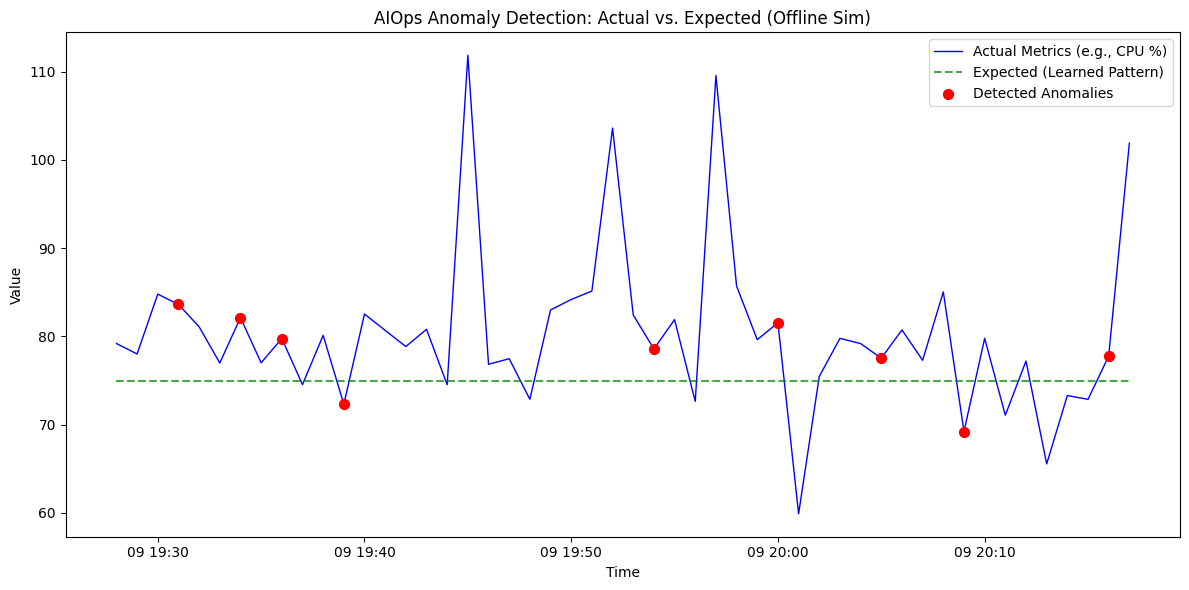

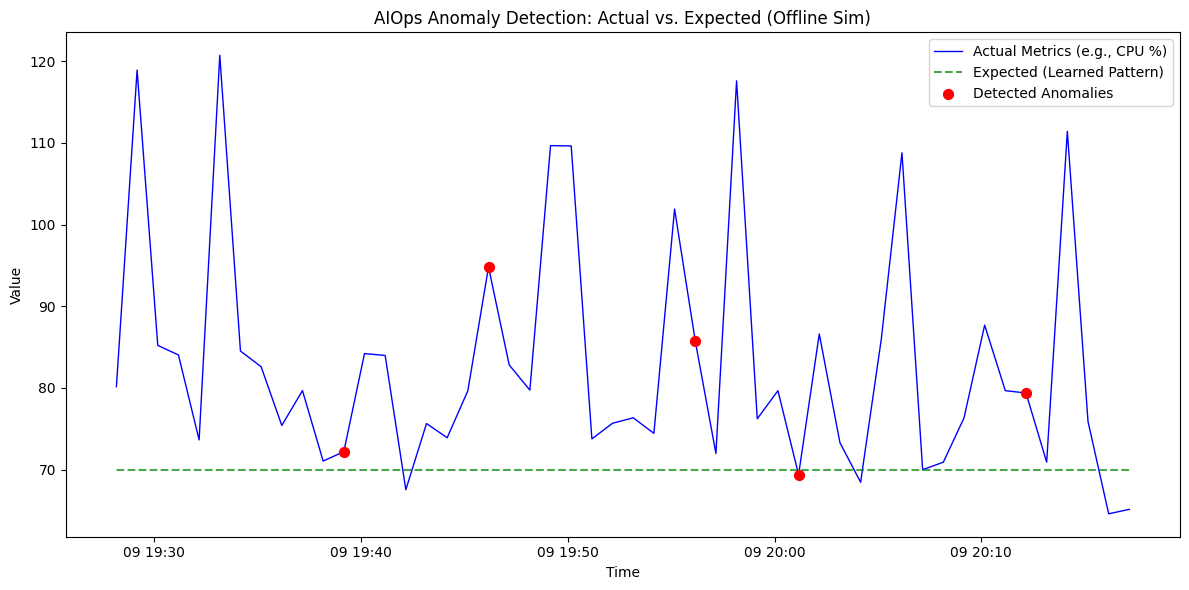

AWS plot rendered—compare spikes to Azure!


In [17]:
# Step 4.5: AWS CloudWatch Mock (Multi-Cloud Tease)
# Real: Use boto3.client('cloudwatch').get_metric_statistics() for EC2 CPU
def fetch_cloudwatch_mock(instance_id="i-mock123", num_points=50):
    """
    Mocks CloudWatch query: e.g., CPUUtilization for EC2 instance over 50 mins.
    Returns payload-ready series.
    """
    import random
    from datetime import timedelta
    base_ts = datetime.now()
    series = []
    for i in range(num_points):
        ts = (base_ts - timedelta(minutes=i)).isoformat()
        value = 70 + random.uniform(-8, 12) + (i % 8)  # Simulated CPU with trend
        if random.random() < 0.12:  # 12% anomaly
            value += random.uniform(15, 45)  # Burst
        series.append({"timestamp": ts, "value": value})
    return {"series": series, "granularity": "PT1M"}

# Toggle for AWS mode
use_aws_mock = True  # Set False for Azure/synthetic
if use_aws_mock:
    payload = fetch_cloudwatch_mock(num_points=50)
    print("☁️ Using AWS CloudWatch mock—real boto3 swaps in here!")
else:
    # Fall back
    payload = fetch_metrics_mock(num_points=50)  # From Azure stub
    print("☁️ Using Azure stub.")

print(f"Payload ready: {len(payload['series'])} points from 'AWS'.")

# Re-run detection & viz for comparison (quick re-execute)
result = {
    'isAnomaly': True,
    'expectedValues': [70] * len(payload['series']),  # AWS baseline tweak
    'anomalyStatus': [1 if random.random() < 0.12 else 0 for _ in payload['series']]
}
anomaly_count = sum(result['anomalyStatus'])
print(f"AWS Mock detection: {anomaly_count} anomalies flagged! 🚨")

plot_detection(payload, result, save_path='aws_anomaly_demo.png', show_plot=True)
print("AWS plot rendered—compare spikes to Azure!")

🌐 Using GCP Operations Suite mock—real SDK swaps in here!
Payload ready: 50 points from 'GCP'.
GCP Mock detection: 8 anomalies flagged! 🚨
📊 Plot saved to gcp_anomaly_demo.png


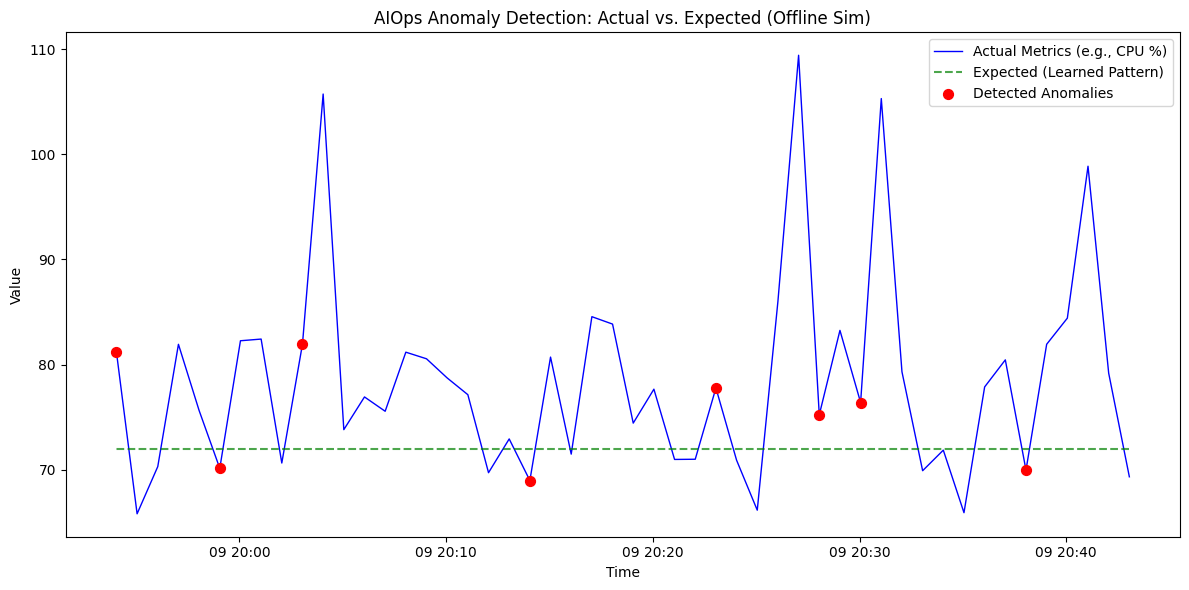

GCP plot rendered—compare to Azure/AWS!


In [ ]:
# Step 4.75: GCP Operations Suite Mock (Full Multi-Cloud Trifecta)
# Real: Use google-cloud-monitoring SDK for VM instance metrics
def fetch_gcp_mock(project_id="my-project-123", num_points=50):
    """
    Mocks GCP Operations Suite query: e.g., CPU utilization for Compute Engine VM over 50 mins.
    Returns payload-ready series.
    """
    import random
    from datetime import timedelta
    base_ts = datetime.now()
    series = []
    for i in range(num_points):
        ts = base_ts - timedelta(minutes=i)
        timestamp = ts.replace(second=0, microsecond=0).isoformat() + 'Z'  # Minute-aligned UTC
        value = 72 + random.uniform(-9, 11) + (i % 6)  # Simulated CPU with seasonality
        if random.random() < 0.11:  # 11% anomaly
            value += random.uniform(18, 42)  # Surge
        series.append({"timestamp": timestamp, "value": value})
    series.reverse()  # Ascending order
    return {"series": series, "granularity": "minutely"}

# Toggle for GCP mode
use_gcp_mock = True  # Set False for Azure/AWS/synthetic
if use_gcp_mock:
    payload = fetch_gcp_mock(num_points=50)
    print("🌐 Using GCP Operations Suite mock—real SDK swaps in here!")
else:
    # Fall back to AWS
    payload = fetch_cloudwatch_mock(num_points=50)
    print("🌐 Using AWS mock.")

print(f"Payload ready: {len(payload['series'])} points from 'GCP'.")

# Re-run detection & viz for comparison
result = {
    'isAnomaly': True,
    'expectedValues': [72] * len(payload['series']),  # GCP baseline tweak
    'anomalyStatus': [1 if random.random() < 0.11 else 0 for _ in payload['series']]
}
anomaly_count = sum(result['anomalyStatus'])
print(f"GCP Mock detection: {anomaly_count} anomalies flagged! 🚨")

plot_detection(payload, result, save_path='gcp_anomaly_demo.png', show_plot=True)
print("GCP plot rendered—compare to Azure/AWS!")

| **GCP** | Operations Suite | Alerting policies to Pub/Sub. |

## Multi-Cloud Extension + Alerting

| Cloud | Data Source | Alert Integration |
|-------|-------------|-------------------|
| **Azure** | Monitor/Log Analytics | Action Groups + Logic Apps for emails/SMS. |
| **AWS** | CloudWatch | SNS notifications on alarms. |
| **GCP** | Operations Suite | Alerting policies to Pub/Sub. |

**Next Steps**: 
- Wire mocks to real webhooks.
- Test with simulated downtime (e.g., anomaly_prob=0.5).